# 4. Model Training (Multi-Task Learning Model based on soft parameter sharing)

In [1]:
# import libraries
import torch
import joblib
import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from datasets import Dataset

from torch import nn
from torch import optim
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from gensim.utils import tokenize
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## 4.1 Load Data

In [2]:
data_df = pd.read_csv('taxonomy_preprocessed2.csv',index_col=0)
data_df

,ID,kingdom_n,phylum_n,class_n,sequence,sequence_kmers
0,ID-10213,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
1,ID-24128,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
2,ID-89036,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
3,ID-65937,1,5,111,TACGGAGGGTGCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTG GGGT...
4,ID-69686,1,5,111,TACGGAGGGTCCAAGCGTTGTCCGGAATCACTGGGTGTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTC GGGT...
...,...,...,...,...,...,...
27400,ID-50131,1,29,89,TACGTAAGGAGCGAGCGTTGTTCGGATTTATTGGGCGTAAAGGGCG...,TACGTA ACGTAA CGTAAG GTAAGG TAAGGA AAGGAG AGGA...
27402,ID-53233,1,9,99,TACGTAGGGTCCGAGCGTTGTCCGGAGTGACTGGGCGTAAAGCGCG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGT AGGGTC GGGT...
27405,ID-59236,1,5,41,TACGGAGGGTCCAAGCGTTATCCGGAATCACTGGGTTTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGG GAGGGT AGGGTC GGGT...
27408,ID-75469,0,10,97,TACCAGCACCCCGAGTGGTCGGGACGATTATTGGGCCTAAAGCATC...,TACCAG ACCAGC CCAGCA CAGCAC AGCACC GCACCC CACC...


## 4.2 Train and Test Split

(1) Split data into train data and test data

In [3]:
split_ratio = 0.2  # The split ratio

Train_data, test_data = train_test_split(data_df, test_size=split_ratio, random_state=1432)
train_data, dev_data = train_test_split(Train_data, test_size=split_ratio, random_state=1432)

(2) Change the data type from DataFrame to Dataset

In [4]:
train_data = Dataset(pa.Table.from_pandas(train_data))
dev_data = Dataset(pa.Table.from_pandas(dev_data))
test_data = Dataset(pa.Table.from_pandas(test_data))

## 4.3 Multi-task Learning Model Training based on LSTM

(1) Change the DNA short sequences into vectors

In [5]:
# 1. Tokenizer
class Tokenizer(object):
    def __call__(self, sequence):
        return word_tokenize(sequence)

vectorizer = CountVectorizer(tokenizer=Tokenizer())  # Construct the vectorizer

vectorizer.fit(train_data['sequence_kmers'])  # Learn the vocabulary

# Document-Term Matrix
X_train = vectorizer.transform(train_data['sequence_kmers'])  # extract training set bags of words
X_dev = vectorizer.transform(dev_data['sequence_kmers'])  # extract validation set bags of words
X_test = vectorizer.transform(test_data['sequence_kmers'])  # extract test set bags of words

vocab = vectorizer.vocabulary_

C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(2) Data Preprocessing

In [6]:
# 2. Data Preprocessing

def encode_text(sample):
    tokens = tokenize(sample['sequence_kmers'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample


def get_text_length(sample):
    tokens = tokenize(sample['sequence_kmers'])  # Tokenize one document
    length = len(list(tokens))
            
    sample['len'] = length
    return sample

def convert_to_data_loader(dataset):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    
    label_tensor_k = torch.from_numpy(np.array(dataset['kingdom_n'])).long()
    label_tensor_p = torch.from_numpy(np.array(dataset['phylum_n'])).long()
    label_tensor_c = torch.from_numpy(np.array(dataset['class_n'])).long()
    
    len_tensor = torch.from_numpy(np.array(dataset['len'])).long() # --> Add len_tensor element
    tensor_dataset = TensorDataset(input_tensor, label_tensor_k, label_tensor_p, label_tensor_c, len_tensor) # --> Add len_tensor element
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

In [7]:
# Preprocess datasets
batch_size = 16

train_data = train_data.map(encode_text)
train_data = train_data.map(get_text_length) # --> Map train_dataset to get_text_length method
train_loader = convert_to_data_loader(train_data)

dev_data = dev_data.map(encode_text)
dev_data = dev_data.map(get_text_length)  # --> Map validation_dataset to get_text_length method
dev_loader = convert_to_data_loader(dev_data)

test_data = test_data.map(encode_text)
test_data = test_data.map(get_text_length)  # --> Map test_dataset to get_text_length method
test_loader = convert_to_data_loader(test_data)

  0%|          | 0/16243 [00:00<?, ?ex/s]

  0%|          | 0/16243 [00:00<?, ?ex/s]

  0%|          | 0/4061 [00:00<?, ?ex/s]

  0%|          | 0/4061 [00:00<?, ?ex/s]

  0%|          | 0/5077 [00:00<?, ?ex/s]

  0%|          | 0/5077 [00:00<?, ?ex/s]

(3) Construct Multi-task learning model based on soft sharing parameter

In [8]:
# 3. Construct Multi-task learning model based on soft sharing parameter
# 3.1 Build the basic model
class STLNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size1, hidden_size2, num_layers, num_classes):
        
        super(STLNN, self).__init__()
        
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        self.embedding_layer = nn.Embedding(vocab_size,embedding_size) # embedding layer
        # Hidden layer (LSTM layer) and the num_layers is the number of recurrent layers
        self.hidden_layer = nn.LSTM(embedding_size,hidden_size1,num_layers,batch_first=True)
        
        self.activation = nn.ReLU() # Hidden layer
        
        self.output_layer= nn.Sequential(
            nn.Linear(hidden_size1,hidden_size2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size2,num_classes)
        )
        
    def forward (self, input_words, sequence_len):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)
        embedded_words = nn.utils.rnn.pack_padded_sequence(embedded_words,sequence_len,batch_first=True,enforce_sorted=False)
        # Compute in LSTM layer
        h0 = torch.randn(self.num_layers, len(input_words), self.hidden_size1) # --> Initialize hidden state h0
        c0 = torch.randn(self.num_layers, len(input_words), self.hidden_size1) # --> Initialize cell state c0
        embedded_words_h, (hn, cn)= self.hidden_layer(embedded_words, (h0,c0))  # --> LSTM layer
        
        # Get the last hidden state or cell state
        embedded_words_h = hn[self.num_layers-1] # Short-term memory
        # embedded_words_c = cn[self.num_layers-1] # Long-term memory

        # Activation layer
        h = self.activation(embedded_words_h) 
        
        # Output layer
        output = self.output_layer(h) 

        return output

In [9]:
# 3.2 Build the multi-task learning model
class TaskInstance(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size1, hidden_size2, num_layers, num_classes, num_tasks):
        super(TaskInstance, self).__init__()
        
        self.num_tasks = num_tasks
        self.task_nets = nn.ModuleList()
        for i in range(num_tasks):
            self.task_nets.append(
                STLNN(
                    vocab_size=vocab_size,
                    embedding_size=embedding_size,
                    hidden_size1=hidden_size1,
                    hidden_size2=hidden_size2[i],
                    num_layers=num_layers,
                    num_classes=num_classes[i]
                )
            )

    
    def forward (self, input_words, sequence_len):
        return torch.cat(
            tuple(task_model(input_words, sequence_len) for task_model in self.task_nets),
            dim=1
        )

In [10]:
# 3.3 Build the multi-task learning model based on soft sharing parameter and construct the loss function
class SoftSharing(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size1, hidden_size2, num_layers, num_classes, num_tasks):
        super(SoftSharing, self).__init__()
        self.model = TaskInstance(
                    vocab_size=vocab_size,
                    embedding_size=embedding_size,
                    hidden_size1=hidden_size1,
                    hidden_size2=hidden_size2,
                    num_layers=num_layers,
                    num_classes=num_classes,
                    num_tasks=num_tasks
        )
    
    def get_param_groups(self):

        param_groups = []
        for out in zip(*[n.named_parameters() for n in self.model.task_nets]):
            if 'weight' in out[0][0]:
                param_groups.append(
                    [
                        out[i][1]
                        for i in range(len(out))
                    ]
                )
        return param_groups

    def soft_loss(self):
        param_groups = self.get_param_groups()

        soft_sharing_loss = torch.tensor(0.)
        for i,params in enumerate(param_groups[:3]):
            soft_sharing_loss += torch.norm(params[0] - params[1], p='fro')+ torch.norm(params[0] - params[2], p='fro')+ torch.norm(params[1] - params[2], p='fro')

        return soft_sharing_loss/3

    def forward(self, input_words, sequence_len, return_loss=False):
        outputs = tuple([self.model(input_words, sequence_len)], )

        if return_loss:
            soft_loss = self.soft_loss()
            outputs = outputs + (soft_loss, )

        return outputs
  

(4) Construct the training model function

In [11]:
# 4. Train model
def train_nn(num_epochs, learning_rate,model, train_dataloader, dev_dataloader):
# def train_nn(num_epochs, learning_rate, model, train_dataloader):
    
#     learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct_k = 0
        total_correct_p = 0
        total_correct_c = 0
        
        total_trained_k = 0
        total_trained_p = 0
        total_trained_c = 0
        
        train_losses_k = []
        train_losses_p = []
        train_losses_c = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels_k, batch_labels_p, batch_labels_c, batch_length) in enumerate(train_dataloader): # --> Add batch_length element
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids, batch_length, return_loss = True) # --> Add batch_length parameter

            # Vertical loss
            batch_loss_k = loss_fn(torch.narrow(output[0],1, 0, num_classes_k), batch_labels_k)
            train_losses_k.append(batch_loss_k.item())
            
            batch_loss_p = loss_fn(torch.narrow(output[0],1, num_classes_k, num_classes_p), batch_labels_p)
            train_losses_p.append(batch_loss_p.item())
            
            batch_loss_c = loss_fn(torch.narrow(output[0],1, num_classes_p, num_classes_c), batch_labels_c)
            train_losses_c.append(batch_loss_c.item())
            
            batch_loss = output[1]+(batch_loss_k+batch_loss_p+batch_loss_c)/3
            
            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()
            # Update the weights using the compute gradients
            optimizer.step()
            # Record the loss from this sample to keep track of progress.

            # Count correct labels so we can compute accuracy on the training set

            predicted_labels_k = torch.narrow(output[0],1, 0, num_classes_k).argmax(1)
            total_correct_k += (predicted_labels_k == batch_labels_k).sum().item()
            total_trained_k += batch_labels_k.size(0)
            
            predicted_labels_p = torch.narrow(output[0],1, num_classes_k, num_classes_p).argmax(1)
            total_correct_p += (predicted_labels_p == batch_labels_p).sum().item()
            total_trained_p += batch_labels_p.size(0)
            
            predicted_labels_c = torch.narrow(output[0],1, num_classes_p, num_classes_c).argmax(1)
            total_correct_c += (predicted_labels_c == batch_labels_c).sum().item()
            total_trained_c += batch_labels_c.size(0)

        train_accuracy_k = total_correct_k/total_trained_k*100
        train_accuracy_p = total_correct_p/total_trained_p*100
        train_accuracy_c = total_correct_c/total_trained_c*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('kingdom'): {:.4f}".format(np.mean(train_losses_k)),
              "Training Accuracy ('kingdom'): {:.4f}%".format(train_accuracy_k))
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('phylum'): {:.4f}".format(np.mean(train_losses_p)),
              "Training Accuracy ('phylum'): {:.4f}%".format(train_accuracy_p))
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('class'): {:.4f}".format(np.mean(train_losses_c)),
              "Training Accuracy ('class'): {:.4f}%".format(train_accuracy_c))
        
        model.eval()  # Switch model to evaluation mode
        
        total_correct_k = 0
        total_correct_p = 0
        total_correct_c = 0
        
        total_trained_k = 0
        total_trained_p = 0
        total_trained_c = 0
        
        dev_losses_k = []
        dev_losses_p = []
        dev_losses_c = []

        for dev_input_ids, dev_labels_k, dev_labels_p, dev_labels_c, dev_length in dev_dataloader:  # --> Add dev_length element

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            dev_output = model(dev_input_ids, dev_length, return_loss = True) # --> Add batch_length parameter
            
            # Compute the loss for the current batch of data
            dev_loss_k = loss_fn(torch.narrow(dev_output[0],1, 0, num_classes_k), dev_labels_k)
            dev_losses_k.append(dev_loss_k.item())
            
            dev_loss_p = loss_fn(torch.narrow(dev_output[0],1, num_classes_k, num_classes_p), dev_labels_p)
            dev_losses_p.append(dev_loss_p.item())
            
            dev_loss_c = loss_fn(torch.narrow(dev_output[0],1, num_classes_p, num_classes_c), dev_labels_c)
            dev_losses_c.append(dev_loss_c.item())
            
            dev_loss = dev_output[1]+(dev_loss_k + dev_loss_p + dev_loss_c) / 3       

            # Perform back propagation to compute the gradients with respect to each weight
            dev_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()
            
            # Count correct labels so we can compute accuracy on the validation set
            predicted_labels_k = torch.narrow(dev_output[0],1, 0, num_classes_k).argmax(1)
            total_correct_k += (predicted_labels_k == dev_labels_k).sum().item()
            total_trained_k += dev_labels_k.size(0)
            
            predicted_labels_p = torch.narrow(dev_output[0],1, num_classes_k, num_classes_p).argmax(1)
            total_correct_p += (predicted_labels_p == dev_labels_p).sum().item()
            total_trained_p += dev_labels_p.size(0)
            
            predicted_labels_c = torch.narrow(dev_output[0],1, num_classes_p, num_classes_c).argmax(1)
            total_correct_c += (predicted_labels_c == dev_labels_c).sum().item()
            total_trained_c += dev_labels_c.size(0)
            
        dev_accuracy_k = total_correct_k/total_trained_k*100
        dev_accuracy_p = total_correct_p/total_trained_p*100
        dev_accuracy_c = total_correct_c/total_trained_c*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('kingdom'): {:.4f}".format(np.mean(dev_losses_k)),
              "Training Accuracy ('kingdom'): {:.4f}%".format(dev_accuracy_k))
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('phylum'): {:.4f}".format(np.mean(dev_losses_p)),
              "Training Accuracy ('phylum'): {:.4f}%".format(dev_accuracy_p))
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss ('class'): {:.4f}".format(np.mean(dev_losses_c)),
              "Training Accuracy ('class'): {:.4f}%".format(dev_accuracy_c))
        

    return model

(5) Construct the prediction function

In [12]:
# 5. The prediction function
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs_k = []  # gold labels to return
    pred_labs_k = []  # predicted labels to return
    
    gold_labs_p = []  # gold labels to return
    pred_labs_p = []  # predicted labels to return
    
    gold_labs_c = []  # gold labels to return
    pred_labs_c = []  # predicted labels to return
    
    for inputs, labels_k, labels_p, labels_c, length in test_loader: # --> Add length element
        test_output = trained_model(inputs, length)  # --> Add length parameter
        predicted_labels_k = torch.narrow(test_output[0],1, 0, num_classes_k).argmax(1)
        predicted_labels_p = torch.narrow(test_output[0],1, num_classes_k, num_classes_p).argmax(1)
        predicted_labels_c = torch.narrow(test_output[0],1, num_classes_p, num_classes_c).argmax(1)

        gold_labs_k.extend(labels_k.tolist())
        pred_labs_k.extend(predicted_labels_k.tolist())
        
        gold_labs_p.extend(labels_p.tolist())
        pred_labs_p.extend(predicted_labels_p.tolist())
        
        gold_labs_c.extend(labels_c.tolist())
        pred_labs_c.extend(predicted_labels_c.tolist())
    
    return gold_labs_k, pred_labs_k, gold_labs_p, pred_labs_p, gold_labs_c, pred_labs_c

(6) Train model

In [13]:
# 6. Construct and train a LSTM model
num_layers = 1 # Set the number of recurrent layers     

vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 30  # number of dimensions for embeddings
hidden_size1 = 300 # number of hidden units
hidden_size2 = [4,100,200]
num_epochs = 10
learning_rate = 0.005

num_classes_k = len(np.unique(train_data['kingdom_n'])) 
num_classes_p = len(np.unique(train_data['phylum_n']))
num_classes_c = len(np.unique(train_data['class_n']))

num_classes = [num_classes_k, num_classes_p, num_classes_c]

num_tasks = 3

In [ ]:
model_lstm = SoftSharing(vocab_size, embedding_size, hidden_size1, hidden_size2, num_layers, num_classes, num_tasks) # Creat a LSTM
trained_model_lstm = train_nn(num_epochs, learning_rate, model_lstm, train_loader, dev_loader) # Train model

Epoch: 1/10 Training Loss ('kingdom'): 0.1413 Training Accuracy ('kingdom'): 95.0563%
Epoch: 1/10 Training Loss ('phylum'): 1.4503 Training Accuracy ('phylum'): 61.2202%
Epoch: 1/10 Training Loss ('class'): 2.2691 Training Accuracy ('class'): 47.2203%
Epoch: 1/10 Training Loss ('kingdom'): 0.0414 Training Accuracy ('kingdom'): 98.2763%
Epoch: 1/10 Training Loss ('phylum'): 0.8306 Training Accuracy ('phylum'): 76.0158%
Epoch: 1/10 Training Loss ('class'): 1.3197 Training Accuracy ('class'): 66.3630%
Epoch: 2/10 Training Loss ('kingdom'): 0.0816 Training Accuracy ('kingdom'): 97.7406%
Epoch: 2/10 Training Loss ('phylum'): 0.7964 Training Accuracy ('phylum'): 77.7319%
Epoch: 2/10 Training Loss ('class'): 1.2598 Training Accuracy ('class'): 68.1832%
Epoch: 2/10 Training Loss ('kingdom'): 0.0378 Training Accuracy ('kingdom'): 98.2763%
Epoch: 2/10 Training Loss ('phylum'): 0.5635 Training Accuracy ('phylum'): 83.8463%
Epoch: 2/10 Training Loss ('class'): 0.8674 Training Accuracy ('class'): 7

In [ ]:
# Save model
joblib.dump(trained_model_lstm, 'mtl_soft_n1_la7_b16_lr1.model')

['mtl_soft_n1_la7_b16_lr1.model']

(7) Model prediction

In [14]:
# 7. Predict model on unseen data
trained_model_lstm = joblib.load('mtl_soft_n1_la7_b16_lr1.model')

gold_labs_k, pred_labs_k, gold_labs_p, pred_labs_p, gold_labs_c, pred_labs_c = predict_nn(trained_model_lstm, test_loader) # Predict the results of test data 

(8) Evaluate model and visualise the results

**$\cdot$Kingdom**

In [15]:
# 8.1 Evaluate the kingdom
acc_k = accuracy_score(gold_labs_k, pred_labs_k)
print(f'Accuracy = {acc_k}')

prec_k = precision_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Precision (macro average) = {prec_k}')

rec_k = recall_score(gold_labs_k, pred_labs_k, average='macro')
print(f'Recall (macro average) = {rec_k}')

f1_k = f1_score(gold_labs_k, pred_labs_k, average='macro')
print(f'F1 score (macro average) = {f1_k}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_k, pred_labs_k))

Accuracy = 0.9740003939334253
Precision (macro average) = 0.48700019696671265
Recall (macro average) = 0.5
F1 score (macro average) = 0.4934144881261226
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.97      1.00      0.99      4945

    accuracy                           0.97      5077
   macro avg       0.49      0.50      0.49      5077
weighted avg       0.95      0.97      0.96      5077



C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packag

<Figure size 7200x3600 with 0 Axes>

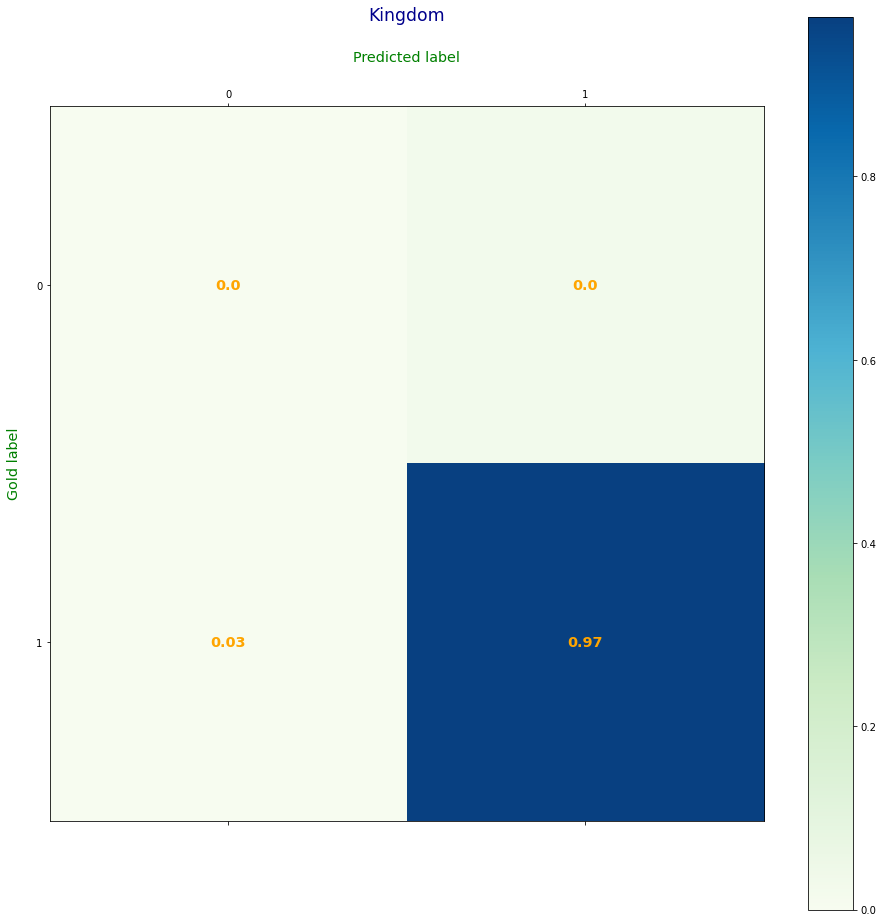

In [21]:
# 8.2 Visualise the results
cm_k = confusion_matrix(gold_labs_k, pred_labs_k, normalize = 'pred')

plt.figure()
plt.matshow(cm_k, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_k.shape[0]):
    for j in range(cm_k.shape[1]):
        plt.text(i,j,str(round(cm_k[i][j],2)),color='orange',fontsize='x-large',ha='center',va='center',weight='semibold')

plt.xlabel('Predicted label',labelpad=-770, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Kingdom', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()

**$\cdot$Phylum**

In [17]:
# 8.3 Evaluate the phylum
acc_p = accuracy_score(gold_labs_p, pred_labs_p)
print(f'Accuracy = {acc_p}')

prec_p = precision_score(gold_labs_p, pred_labs_p, average='macro')
print(f'Precision (macro average) = {prec_p}')

rec_p = recall_score(gold_labs_p, pred_labs_p, average='macro')
print(f'Recall (macro average) = {rec_p}')

f1_p = f1_score(gold_labs_p, pred_labs_p, average='macro')
print(f'F1 score (macro average) = {f1_p}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_p, pred_labs_p))

Accuracy = 0.9474098877289738
Precision (macro average) = 0.8046067892998732
Recall (macro average) = 0.780796872737316
F1 score (macro average) = 0.7822655102828362
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.87      0.94      0.90       316
           2       0.94      0.97      0.96       350
           3       0.57      0.62      0.59        21
           4       0.00      0.00      0.00         2
           5       0.99      0.99      0.99       651
           6       0.40      0.67      0.50         3
           7       1.00      0.96      0.98        28
           8       0.72      0.81      0.76        26
           9       0.87      0.90      0.89       195
          10       1.00      0.90      0.95        21
          11       0.94      0.94      0.94       169
          12       0.87      0.61      0.71        33
          13       0.80      0.89      0.84        18
          14       1.00

<Figure size 432x288 with 0 Axes>

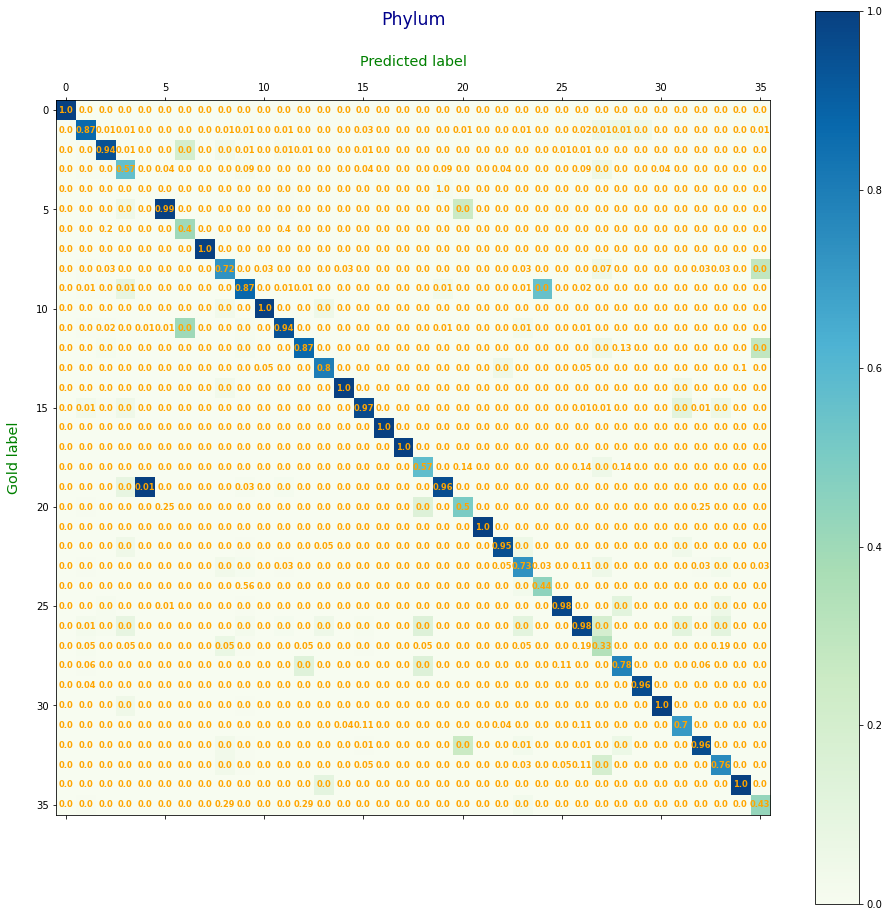

In [18]:
# 8.4 Visualise the results
cm_p = confusion_matrix(gold_labs_p, pred_labs_p, normalize = 'pred')

plt.figure()
plt.rcParams["figure.figsize"] = [100.00, 50.00]
plt.matshow(cm_p, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_p.shape[0]):
    for j in range(cm_p.shape[1]):
        plt.text(i,j,str(round(cm_p[i][j],2)),color='orange',fontsize='small',ha='center',va='center',weight='semibold')

plt.xlabel('Predicted label',labelpad=-760, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Phylum', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()

**$\cdot$Class**

In [19]:
# 8.5 Evaluate the class
acc_c = accuracy_score(gold_labs_c, pred_labs_c)
print(f'Accuracy = {acc_c}')

prec_c = precision_score(gold_labs_c, pred_labs_c, average='macro')
print(f'Precision (macro average) = {prec_c}')

rec_c = recall_score(gold_labs_c, pred_labs_c, average='macro')
print(f'Recall (macro average) = {rec_c}')

f1_c = f1_score(gold_labs_c, pred_labs_c, average='macro')
print(f'F1 score (macro average) = {f1_c}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(gold_labs_c, pred_labs_c))

Accuracy = 0.905062044514477
Precision (macro average) = 0.7813689331512443
Recall (macro average) = 0.7421232613743596
F1 score (macro average) = 0.7322150667358294
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.73      0.50      0.59        16
           2       0.50      0.44      0.47        18
           3       1.00      1.00      1.00         1
           4       0.33      0.33      0.33         3
           5       0.92      0.92      0.92        71
           6       0.91      0.83      0.87        12
           7       0.99      0.92      0.95        74
           8       0.89      0.91      0.90        34
           9       0.91      1.00      0.96       172
          10       0.96      0.95      0.95       647
          11       0.65      0.91      0.76        90
          12       0.00      0.00      0.00         2
          13       1.00      0.75      0.86         4
          14       0.83

C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Angela.Chen\miniconda3\lib\site-packag

<Figure size 7200x3600 with 0 Axes>

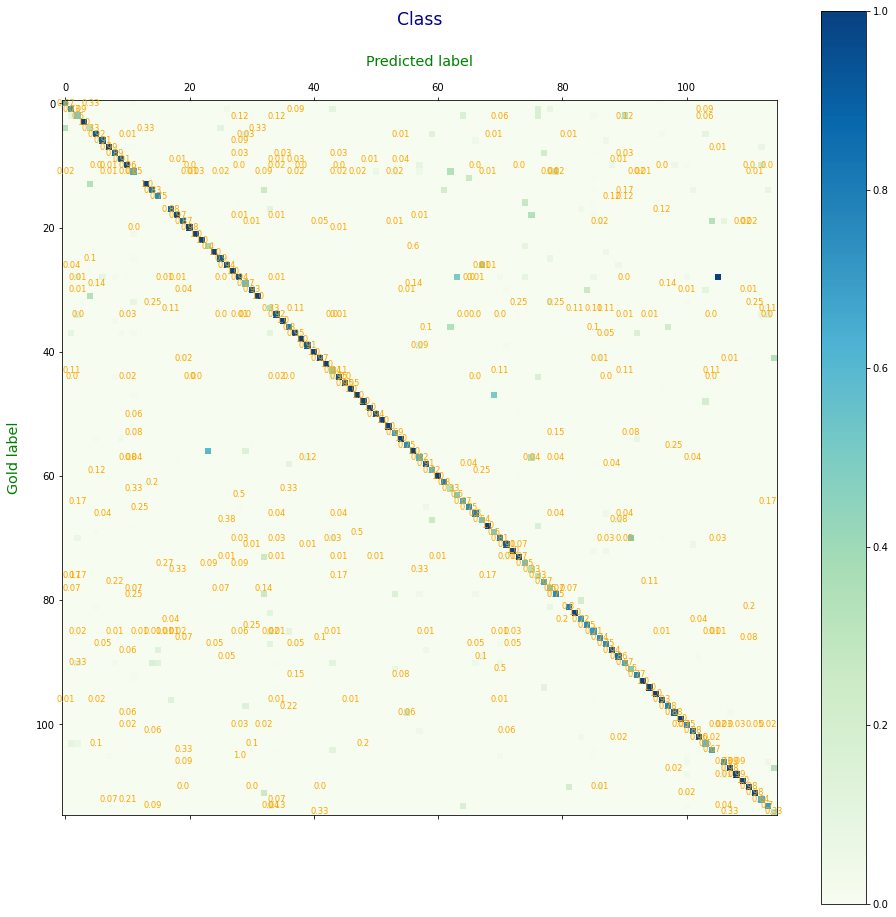

In [20]:
# 8.6 Visualise the results
cm_c = confusion_matrix(gold_labs_c, pred_labs_c, normalize = 'pred')

plt.figure()
plt.rcParams["figure.figsize"] = [100.00, 50.00]
plt.matshow(cm_c, cmap = plt.cm.GnBu)
plt.colorbar()

for i in range(cm_c.shape[0]):
    for j in range(cm_c.shape[1]):
        if cm_c[i][j] !=0:
            plt.text(i,j,str(round(cm_c[i][j],2)),color='orange',fontsize='small',ha='center',va='center',weight='normal')

plt.xlabel('Predicted label',labelpad=-760, fontsize='x-large',color= 'green')
plt.ylabel('Gold label',labelpad=15, fontsize='x-large',color= 'green')
plt.title('Class', fontsize='xx-large',pad=30,color= 'darkblue')
plt.show()